In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import utils.functions as functions
from utils.functions import *
import importlib
import json
from utils.graph_repair import repair_network
import matplotlib.patches as patches

/Users/alireza/opt/miniconda3/envs/NYU-DL/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ImportError: dlopen(/Users/alireza/opt/miniconda3/envs/NYU-DL/lib/python3.10/site-packages/scipy/spatial/_distance_wrap.cpython-310-darwin.so, 0x0002): symbol not found in flat namespace '_npy_copysign'

In [7]:
cmap = get_colormap()
input_file = 'dataset/worms'

In [8]:
worm_dicts = read_input(input_file, remove_trend=True, smooth_spikes=True, mean_zero=True)

In [9]:
averaged_results = calculate_metrics(worm_dicts, use_annotations = True, return_average = True)

100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


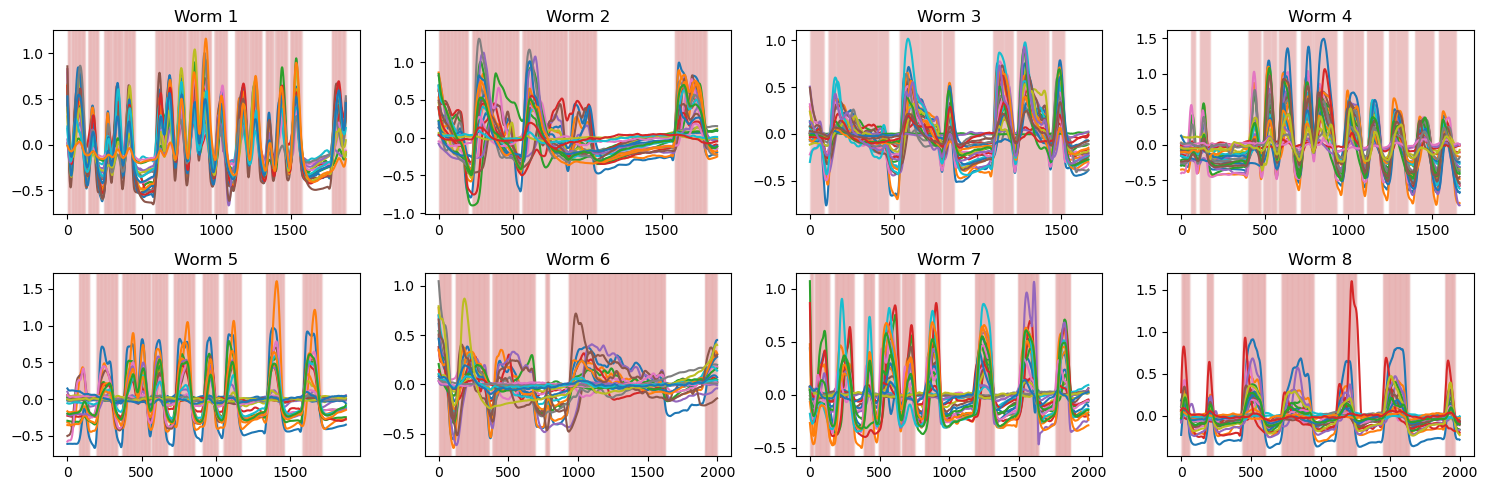

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax = ax.flatten()

for i, worm_dict in enumerate(worm_dicts):
    for key, value in worm_dict.items():
        if key == 'annot':
            for idx in range(len(value)):
                if value[idx] > 1:
                    ax[i].axvspan(idx, idx, color='tab:red', alpha=0.03)
        else:
            ax[i].plot(value)
    ax[i].set_title(f'Worm {i+1}')

plt.tight_layout()
# fig.savefig('plots/signals.png')
# plt.close()

In [13]:
pairs = list(set(averaged_results.keys()))

## to replicate the results in the paper
all_neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06']

mapping_neuron_to_idx = {all_neurons[idx]:idx for idx in range(len(all_neurons))}
mapping_idx_to_neuron = {idx:all_neurons[idx] for idx in range(len(all_neurons))}

Generate matrices

In [20]:
matrices = {}
modified_matrices = {}

# Metrics are the same across pairs, hence the [0]

for metric in averaged_results[pairs[0]]:
    matrix = np.ones((len(mapping_neuron_to_idx), len(mapping_neuron_to_idx)))
    for pair in pairs:
        if pair[0] in mapping_neuron_to_idx and pair[1] in mapping_neuron_to_idx:
            matrix[mapping_neuron_to_idx[pair[0]], mapping_neuron_to_idx[pair[1]]] = averaged_results[pair][metric]
            matrix[mapping_neuron_to_idx[pair[1]], mapping_neuron_to_idx[pair[0]]] = averaged_results[pair][metric]
    
    threshold = calculate_percolation(matrix)
    modified_matrix = np.where(matrix >= threshold, matrix, 0)
    
    matrices[metric] = matrix
    modified_matrices[metric] = modified_matrix

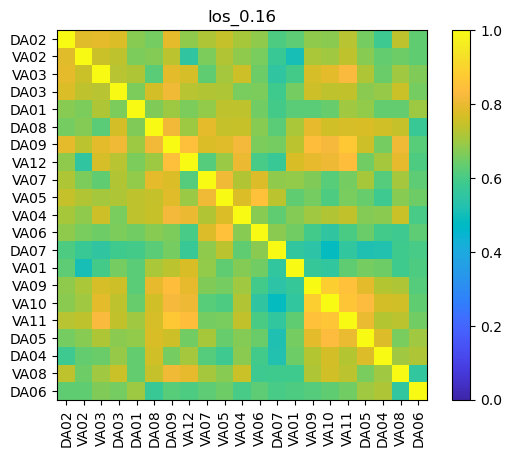

In [23]:
metric = 'los_0.16'

plt.imshow(matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar()
# plt.savefig(f'plots/{metric}.png')
# plt.close()

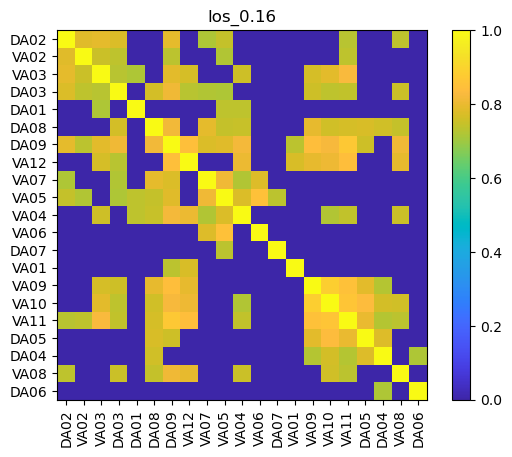

In [22]:
metric = 'los_0.16'

plt.imshow(modified_matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar()
# plt.savefig(f'plots/{metric}.png')
# plt.close()

In [ ]:
RECALCULATE = False

if not RECALCULATE:
    with open('precomputed/all_cliques_detrend_demean_despike.json', 'r') as file:
        # Load the JSON data from the file
        all_cliques = json.load(file)
else:
    all_cliques = {}

    for method in ['louvain', 'clique']:
        for name in modified_matrices.keys():

            if method == 'louvain':
                louvain_results = louvain_clustering_best_modularity(modified_matrices[name], all_neurons, 1000)
                clusters = louvain_results
                all_cliques[name+'_'+method] = louvain_results
            elif method == 'clique':
                valid_cliques = check_cliques_struc_v2(modified_matrices[name], all_neurons, 2, 9)
                refined_cliques = refine_cliques(valid_cliques)
                clusters = refined_cliques
                all_cliques[name+'_'+method] = refined_cliques
            
            with open(f'colorings/{method[:4]}_{name}_colors_collapsed.txt', 'w') as f:
                for idx, clique in enumerate(clusters):
                    for node in clique:
                        print(f'{node}\t{idx}', file=f)
                        
                print(f'AVE\t{idx+1}', file=f)
                
                print(f'AVD\t{idx+2}', file=f)
                
                print(f'AVA\t{idx+3}', file=f)
                
            with open(f'colorings/{method[:4]}_{name}_colors_uncollapsed.txt', 'w') as f:
                for idx, clique in enumerate(clusters):
                    for node in clique:
                        print(f'{node}\t{idx}', file=f)
                    
                print(f'AVEL\t{idx+1}', file=f)
                print(f'AVER\t{idx+1}', file=f)
                
                print(f'AVDL\t{idx+2}', file=f)
                print(f'AVDR\t{idx+2}', file=f)
                
                print(f'AVAL\t{idx+3}', file=f)
                print(f'AVAR\t{idx+3}', file=f)
        
    json_string = json.dumps(all_cliques)

    # Save the JSON string to a file
    with open("precomputed/all_cliques_detrend_demean_despike.json", "w") as f:
        f.write(json_string)
        

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

cooccurrence_matrix = get_cooccurrence_matrix(list(all_cliques.values()), mapping_neuron_to_idx)

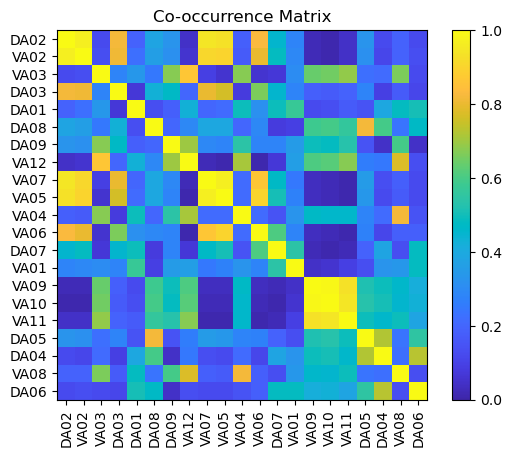

In [30]:
plt.imshow(cooccurrence_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title('Co-occurrence Matrix')
plt.colorbar()

Text(0, 0.5, 'Distance')

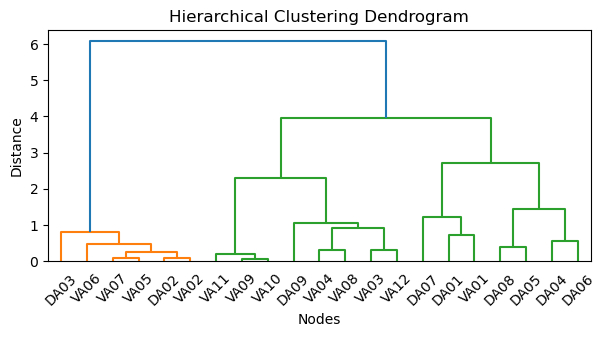

In [ ]:
# Step 4: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 5: Plot the Dendrogram
plt.figure(figsize=(7, 3))
dendo = dendrogram(linkage_matrix, labels=all_neurons)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nodes")
plt.ylabel("Distance")
# plt.savefig('plots/dendogram.png')
# plt.close()

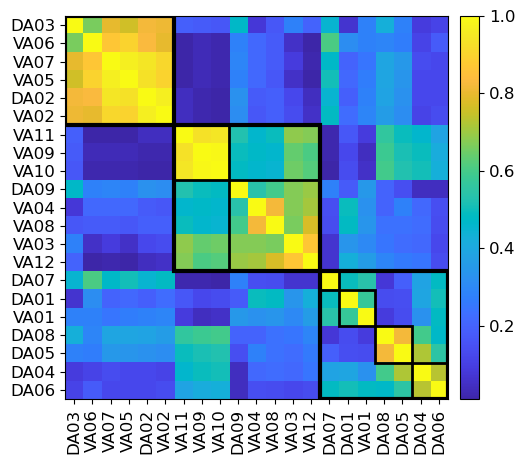

In [48]:
plt.rcParams.update({'font.size': 12})

plt.imshow(cooccurrence_matrix, cmap=cmap)
plt.xticks(range(len(new_node_order)), new_node_order, rotation=90)
plt.yticks(range(len(new_node_order)), new_node_order)
plt.colorbar(pad=0.02)

squares = [
    [0, 5, 3],
    [6, 13, 3],
    [14, 20, 3],
    
    [0, 5, 2],
    [6, 8, 2],
    [9, 13, 2],
    [14, 14, 2],
    [15, 16, 2],
    [17, 18, 2],
    [19, 20, 2],
]

for start, end, thickness in squares:
    # Add a square (rectangle with equal height and width)
    ax = plt.gca()
    rect = patches.Rectangle(
        (start - 0.5, start - 0.5),  # Rectangle starts slightly offset to align with pixels
        end - start + 1,            # Width
        end - start + 1,            # Height
        linewidth=thickness,                    # Line thickness
        edgecolor='black',                # Line color
        facecolor='none'                # Transparent fill
    )
    ax.add_patch(rect)

plt.tight_layout()
# plt.savefig('plots/cooccurrence.png')
# plt.close()

In [ ]:
RECALCULATE = False

if not RECALCULATE:
    for n_cluster in [3,4,5,6,7,8,9,10,11,12,13,14]:
        clusters = fcluster(linkage_matrix, n_cluster, criterion='maxclust')
        
        with open(f'colorings/cons_{n_cluster}_colors_collapsed.txt', 'w') as f:
            max_id = np.max(clusters)
            for idx, neuron in enumerate(all_neurons):
                print(f'{neuron}\t{clusters[idx]}', file=f)
                
            print(f'AVE\t{max_id+1}', file=f)
            
            print(f'AVD\t{max_id+2}', file=f)
            
            print(f'AVA\t{max_id+3}', file=f)
            
        with open(f'colorings/cons_{n_cluster}_colors_uncollapsed.txt', 'w') as f:
            max_id = np.max(clusters)
            for idx, neuron in enumerate(all_neurons):
                print(f'{neuron}\t{clusters[idx]}', file=f)
                
            print(f'AVEL\t{max_id+1}', file=f)
            print(f'AVER\t{max_id+1}', file=f)
        
            print(f'AVDL\t{max_id+2}', file=f)
            print(f'AVDR\t{max_id+2}', file=f)
        
            print(f'AVAL\t{max_id+3}', file=f)
            print(f'AVAR\t{max_id+3}', file=f)

### Repair

In [ ]:
for collapsed in ['collapsed', 'uncollapsed']:
    print(f'####### running, {collapsed}...')
    
    # Choose if there will be a prohibited edge list:
    prohibit_file = f"connectomes/{collapsed}_prohibited_edges.txt"
    # prohibit_file = None
    
    df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)
    res = {}
    for n_cluster in [3,4,5,6]:
        print(f'############### cons, {str(n_cluster)}...')
        df = pd.read_csv(f"colorings/cons_{n_cluster}_colors_{collapsed}.txt", sep='\t', header=None)
        res['cons-' + str(n_cluster) + f'-{collapsed}'] = {}
        for a in [1]:
            for b in [1]:
                
                shuffled_results = []
                while True:
                    for i in range(500):
                        while True:
                            # try and except to avoid unrepairable networks
                            try:
                                df_copy = shuffle_classes_preserving_groups(df)
                                df_copy.to_csv(f"colorings/temp_shuffle.txt", sep='\t', header=None, index=None)
                                EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/temp_shuffle.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/temp_shuffle_o_", a, b, prohibit_file_path=prohibit_file)
                                shuffled_results.append(modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight_new'))
                                break
                            except:
                                continue
                            
                    # check if the last 500 samples are stable compared to whole (with tolerance of 0.001), also run at least 1000 and not more than 10000
                    if not check_stability(shuffled_results, 0.001, 10000, 1000, 500):
                        print(f'N samples = {len(shuffled_results)}')
                        print(f'{np.mean(shuffled_results)}, {np.std(shuffled_results)}')
                        break
                    
                repair = 1e9
                for n in range(1000):
                    EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_{str(n_cluster)}_colors_{collapsed}.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_consensous_{str(n_cluster)}_colors_o_", a, b, prohibit_file_path=prohibit_file)
                    repair_percentage = modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight_new')
                    repair = min(repair, repair_percentage)
                    
                # repair and p-value tuple
                res['cons-' + str(n_cluster) + f'-{collapsed}'][(a,b)] = (repair, 
                                                                    1.0*(np.array(shuffled_results) < repair).sum() / len(shuffled_results))
                print(f'a={a}, b={b}, epsilon={repair}, p_val={1.0*(np.array(shuffled_results) < repair).sum() / len(shuffled_results)}')
        pd.DataFrame(res).to_csv(f'res_cons_none_{collapsed}.csv')

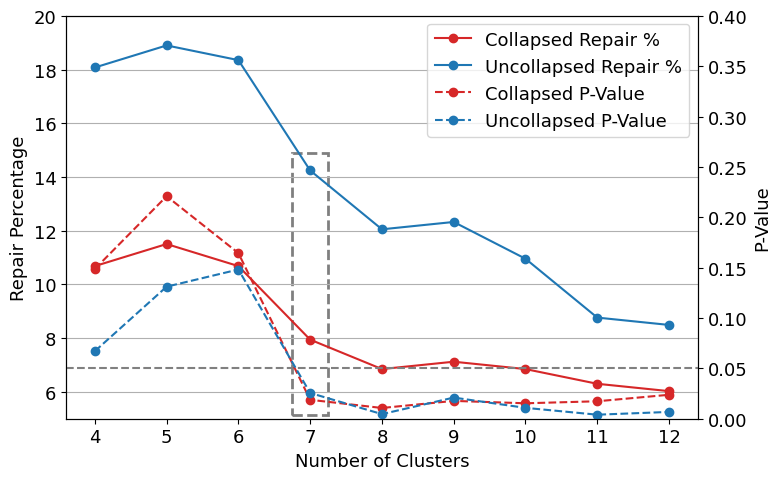

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 13})

# Plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot the first numbers
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Repair Percentage')
ax1.tick_params(axis='y')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-Value')

ax2.tick_params(axis='y')
ax2.axhline(y=0.05, color='grey', linestyle='--')


df = pd.read_csv('res_cons_prohibit_collapsed.csv')
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
ax2.plot(n_colors, pvals, '--o', label='Collapsed P-Value', color='tab:red')
ax1.plot(n_colors, repairs, '-o', label='Collapsed Repair %', color='tab:red')


##############################

df = pd.read_csv('res_cons_prohibit_uncollapsed.csv')
df = df[[x for idx, x in enumerate(df.columns) if 'un' in x or idx < 2]]
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

repairs = []
pvals = []
n_colors = []

for row in df.iterrows():
    n_colors.append(int(row[0]))
    best_repair = 1e100
    best_pval = 1.0
    
    for tup in row[1].values:
        if best_pval < 0.05 and tup[1] < 0.05 and tup[0] < best_repair: # already found a significant result, looking for better repair
            best_repair = tup[0]
            best_pval = tup[1]
        elif tup[1] < best_pval: # not found a significant result yet
            best_pval = tup[1]
            best_repair = tup[0]
    
    repairs.append(best_repair*100.0)
    pvals.append(best_pval)
    
    
ax2.plot(n_colors, pvals, '--o', label='Uncollapsed P-Value', color='tab:blue')
ax1.plot(n_colors, repairs, '-o', label='Uncollapsed Repair %', color='tab:blue')

ax1.set_xticks([3,4,5,6,7,8,9,10,11], [4,5,6,7,8,9,10,11,12])

ax1.set_ylim([5, 20])
ax2.set_ylim([0,0.4])

rect = Rectangle((5.75, 5.15), 0.5, 9.75, 
                 linewidth=2, edgecolor='black', linestyle="--", facecolor='none', alpha=0.5)
ax1.add_patch(rect)

fig.tight_layout()  # Adjust layout to prevent overlap
fig.legend(loc='upper right', bbox_to_anchor=(0.885,0.95))
ax1.grid('on','major','y')
# fig.savefig('plots/percentages_and_pvalues.png', dpi=400)

In [4]:
orig = pd.read_csv('connectomes/collapsed_varshney.graph.txt', sep='\t', header=None)
prohib = pd.read_csv('connectomes/collapsed_prohibited_edges.txt', sep='\t', header=None)

neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06', 'AVA', 'AVD', 'AVE']
mapping_neuron_to_idx = {neurons[idx]:idx for idx in range(len(neurons))}

orig_m = np.zeros((len(neurons), len(neurons)))
prohib_m = np.zeros((len(neurons), len(neurons)))

for row in orig.iterrows():
    orig_m[mapping_neuron_to_idx[row[1][0]]][mapping_neuron_to_idx[row[1][1]]] = 1
    
for row in prohib.iterrows():
    prohib_m[mapping_neuron_to_idx[row[1][0]]][mapping_neuron_to_idx[row[1][1]]] = 1

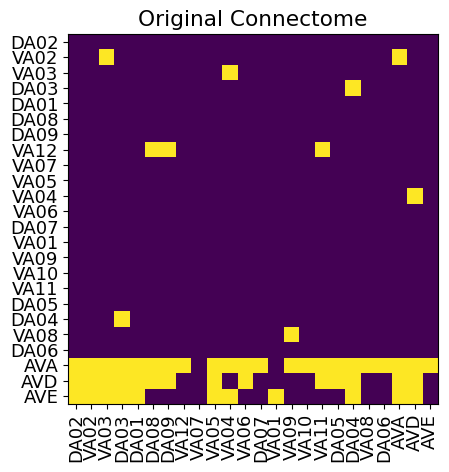

In [8]:
plt.imshow(orig_m)
plt.xticks(range(len(neurons)), neurons, rotation=90)
plt.yticks(range(len(neurons)), neurons)
plt.title('Original Connectome');

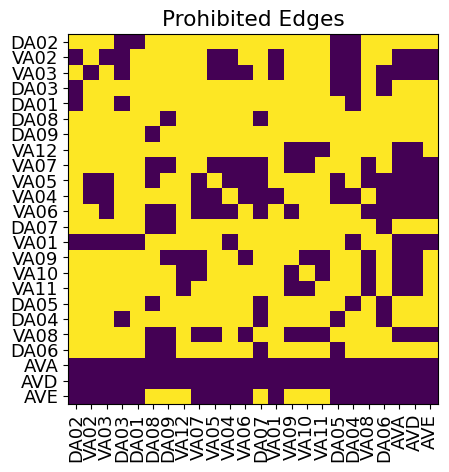

In [15]:
plt.imshow(prohib_m)
plt.xticks(range(len(neurons)), neurons, rotation=90)
plt.yticks(range(len(neurons)), neurons)
plt.title('Prohibited Edges');